# Library Imports

In [1]:
# Import necessary libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, precision_score, recall_score, f1_score

# Importing necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


# Configure visualization settings
sns.set_context("notebook", font_scale=1.5)

# Load the dataset
#file_path = 'C:/Users/pc/Desktop/politecnico/b-FINTECH/business cases/Fintech_BC/BC4/data/Dataset4_EWS.xlsx'
file_path = './data/Dataset4_EWS.xlsx'

## Data Loading

In [2]:
# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

# Load the data from the Excel file
data_df = pd.read_excel(file_path, sheet_name='Markets') # First sheet: Market data
metadata_df = pd.read_excel(file_path, sheet_name='Metadata') # Second sheet: Metadata

# Check the structure of the loaded data
print("Data columns:", data_df.columns.tolist())

# Extract date and anomaly label columns
date_col = 'Date' if 'Date' in data_df.columns else data_df.columns[0]
y_col = 'Y' if 'Y' in data_df.columns else None

# Convert dates to datetime format
data_df[date_col] = pd.to_datetime(data_df[date_col], dayfirst=True)  # Date format is dd/mm/yy

# Set date as index
data_df = data_df.set_index(date_col)

# Extract features (all columns except Y if it exists)
if y_col:
    X_df = data_df.drop(y_col, axis=1)
    y = data_df[y_col].values
else:
    X_df = data_df
    y = None

# Display basic information about the dataset
print(f"Data shape: {X_df.shape}")
print(f"Total number of records: {len(X_df)}")
print(f"Time period: from {X_df.index.min().strftime('%m/%d/%Y')} to {X_df.index.max().strftime('%m/%d/%Y')}")
print(f"Frequency: {pd.infer_freq(X_df.index) or 'Weekly'}")
print(f"Number of variables: {X_df.shape[1]}")
if y_col:
    print(f"Number of anomalies: {np.sum(y == 1)} ({np.mean(y == 1)*100:.2f}%)")

# Create a more comprehensive metadata table with additional statistics
enhanced_metadata = []

# Determine the correct column names for ticker and description
ticker_col = 'ticker' if 'ticker' in metadata_df.columns else metadata_df.columns[0]
desc_col = 'description' if 'description' in metadata_df.columns else metadata_df.columns[1] if len(metadata_df.columns) > 1 else ticker_col

for ticker in X_df.columns:
    # Get metadata for this ticker if available
    meta_row = metadata_df[metadata_df[ticker_col] == ticker] if ticker in metadata_df[ticker_col].values else pd.DataFrame()

    # Get description or use ticker if not found
    description = meta_row[desc_col].values[0] if not meta_row.empty and desc_col in meta_row.columns else ticker

    # Calculate statistics for this series
    series = X_df[ticker]

    enhanced_metadata.append({
        'Ticker': ticker,
        'Description': description,
        'Mean': series.mean(),
        'Std.Dev': series.std(),
        'Min': series.min(),
        'Max': series.max(),
        'Missing values': series.isna().sum(),
        'Missing (%)': f"{series.isna().mean()*100:.2f}%"
    })

# Create enhanced metadata dataframe
enhanced_meta_df = pd.DataFrame(enhanced_metadata)

# Display the enhanced metadata
print("\nMetadata and statistics:")
display(enhanced_meta_df)


Data columns: ['Data', 'BDIY', 'CRY', 'Cl1', 'DXY', 'ECSURPUS', 'EMUSTRUU', 'EONIA', 'GBP', 'GT10', 'GTDEM10Y', 'GTDEM2Y', 'GTDEM30Y', 'GTGBP20Y', 'GTGBP2Y', 'GTGBP30Y', 'GTITL10YR', 'GTITL2YR', 'GTITL30YR', 'GTJPY10YR', 'GTJPY2YR', 'GTJPY30YR', 'JPY', 'LF94TRUU', 'LF98TRUU', 'LG30TRUU', 'LMBITR', 'LP01TREU', 'LUACTRUU', 'LUMSTRUU', 'MXBR', 'MXCN', 'MXEU', 'MXIN', 'MXJP', 'MXRU', 'MXUS', 'US0001M', 'USGG2YR', 'USGG30YR', 'USGG3M', 'VIX', 'XAUBGNL', 'Y']
Data shape: (1111, 42)
Total number of records: 1111
Time period: from 01/11/2000 to 04/20/2021
Frequency: W-TUE
Number of variables: 42
Number of anomalies: 237 (21.33%)

Metadata and statistics:


,Ticker,Description,Mean,Std.Dev,Min,Max,Missing values,Missing (%)
0,BDIY,Baltic Dry Index,2259.860486,2017.811888,291.00000,11793.00000,0,0.00%
1,CRY,TR/CC CRB ER Index,245.247649,68.278081,106.29290,467.57000,0,0.00%
2,Cl1,Generic 1st 'CL' Future,60.708101,25.900813,10.01000,140.97000,0,0.00%
3,DXY,DOLLAR INDEX SPOT,90.934982,11.379095,71.32900,119.82000,0,0.00%
4,ECSURPUS,Bloomberg ECO US Surprise Inde,0.036153,0.349453,-0.97400,0.99100,0,0.00%
5,EMUSTRUU,EM USD Aggregate,704.379495,309.951768,230.52670,1286.35300,0,0.00%
6,EONIA,EMMI EURO OverNight Index Aver,1.363676,1.721894,-0.49800,5.73000,0,0.00%
7,GBP,British Pound Spot,1.569618,0.212340,1.17230,2.08520,0,0.00%
8,GT10,US TREASURY N/B,3.266748,1.332464,0.50800,6.74800,0,0.00%
9,GTDEM10Y,BUNDESREPUB. DEUTSCHLAND,2.448365,1.851558,-0.79400,5.64400,0,0.00%


# Data Preprocessing

In [3]:
# Extract columns related to indices and currencies
indices_currencies = [col for col in X_df.columns if col in [
    'XAUBGNL', 'BDIY', 'CRY', 'Cl1', 'DXY', 'EMUSTRUU', 'GBP', 'JPY', 'LF94TRUU',
    'LF98TRUU', 'LG30TRUU', 'LMBITR', 'LP01TREU', 'LUACTRUU', 'LUMSTRUU',
    'MXBR', 'MXCN', 'MXEU', 'MXIN', 'MXJP', 'MXRU', 'MXUS', 'VIX'
]]

# Extract columns related to interest rates
interest_rates = [col for col in X_df.columns if col in [
    'EONIA', 'GTDEM10Y', 'GTDEM2Y', 'GTDEM30Y', 'GTGBP20Y', 'GTGBP2Y', 'GTGBP30Y',
    'GTITL10YR', 'GTITL2YR', 'GTITL30YR', 'GTJPY10YR', 'GTJPY2YR', 'GTJPY30YR',
    'US0001M', 'USGG3M', 'USGG2YR', 'GT10', 'USGG30YR'
]]

#############################################################################
###################### Create stationary data ###############################
#############################################################################

# Create a new dataframe for stationary data
stationary_df = pd.DataFrame(index=X_df.index[1:])

# Apply log-differences to indices and currencies (always positive)
for col in indices_currencies:
    if col in X_df.columns:
        stationary_df[col] = np.diff(np.log(X_df[col]))

# Apply first differences to interest rates (can be negative or very close to 0)
for col in interest_rates:
    if col in X_df.columns:
        stationary_df[col] = np.diff(X_df[col])

# Keep Bloomberg Economic US Surprise Index as is (already stationary)
if 'ECSURPUS' in X_df.columns:
    stationary_df['ECSURPUS'] = X_df['ECSURPUS'].values[1:]

# Adjust the response variable to match the new data length
if y is not None:
    y_stationary = y[1:]
else:
    y_stationary = None


# Data Visualization

We plot the data density and the density of the log-differences the see if we can see any pattern to better understand how to classify the data.

In [ ]:
plt.figure(figsize=(20, 40))
# Calculate the number of rows and columns for the subplot grid
num_cols = 4
num_rows = -(-len(stationary_df.columns) // num_cols)  # Ceiling division

# For each column in the stationary dataframe, plot separate histograms for y=0 and y=1
for i, col in enumerate(stationary_df.columns):
    if col != 'y':  # Skip the target column itself
        plt.subplot(num_rows, num_cols, i + 1)
        
        # Class 0 (blue)
        plt.hist(stationary_df[y_stationary == 0][col].dropna(), 
                 bins=30, color='blue', alpha=0.5, label='y=0', density = True)
        
        # Class 1 (red)
        plt.hist(stationary_df[y_stationary == 1][col].dropna(), 
                 bins=30, color='red', alpha=0.5, label='y=1', density = True)
        
        plt.title(col)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
print("X_df shape", X_df.shape)

plt.figure(figsize=(20, 40))
# Calculate the number of rows and columns for the subplot grid
num_cols = 4
num_rows = -(-len(X_df.columns) // num_cols)  # Ceiling division
y = data_df[y_col].values
X_df = data_df.drop(y_col, axis=1)


# For each column in the stationary dataframe, plot separate histograms for y=0 and y=1
for i, col in enumerate(X_df.columns):
    if col != 'y':  # Skip the target column itself
        plt.subplot(num_rows, num_cols, i + 1)
        
        # Class 0 (blue)
        plt.hist(X_df[y == 0][col].dropna(), 
                 bins=30, color='blue', alpha=0.5, label='y=0', density = True)
        
        # Class 1 (red)
        plt.hist(X_df[y == 1][col].dropna(), 
                 bins=30, color='red', alpha=0.5, label='y=1', density = True)
        
        plt.title(col)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

As we can see, doesn't show a clear pattern to classify the data.

# Bayesian Neural Network (BNN)

## What is a BNN?
A Bayesian Neural Network (BNN) is a type of neural network that incorporates Bayesian inference into its architecture. Unlike traditional neural networks, which provide point estimates for weights and biases, BNNs treat these parameters as probability distributions. This allows BNNs to quantify uncertainty in their predictions, making them particularly useful in scenarios where data is noisy or to better understand the model's confidence in its predictions.

## Why use a BNN?
1. **Uncertainty Quantification**: BNNs provide a measure of uncertainty in predictions, which is crucial in many applications, such as our case since both by the legislator and by the stake-holders we need to understand the uncertainty of the model.
2. **Robustness to Overfitting**: By treating weights as distributions, BNNs can be more robust to overfitting, especially in cases with limited data.
3. **Incorporation of Prior Knowledge**: BNNs allow the incorporation of prior knowledge into the model, which can be beneficial in scenarios where data is scarce or noisy.

Our implementation of a BNN is based on the following classes:

## BayesianLayer Class
A custom linear layer implementing Bayesian neural network functionality with support for various activation functions and batch normalization.

### Initialization Parameters
- **in_features**: Number of input features
- **out_features**: Number of output features
- **dropout_prob**: Dropout probability (default: 0.1)
- **activation**: Choice of activation function ('relu', 'leaky_relu', 'selu', 'gelu', 'swish')
- **use_batch_norm**: Flag to enable/disable batch normalization

## ResidualBlock Class
Implements a residual connection block using two BayesianLayers for improved training stability.

### Architecture
Consists of:
- Two identical BayesianLayers
- Residual connection around the block
- Optional batch normalization and dropout

## BayesianNN Class
Full Bayesian neural network implementation with configurable architecture and residual connections.

### Configuration Options
- **input_dim**: Input feature dimensionality
- **hidden_dims**: List of hidden layer dimensions
- **dropout_probs**: List of dropout probabilities per layer
- **activation**: Global activation function choice
- **use_batch_norm**: Flag for batch normalization
- **use_residual**: Flag to enable/disable residual connections

## CosineWarmupScheduler Class
Custom learning rate scheduler combining linear warmup with cosine annealing decay.

### Parameters
- **optimizer**: PyTorch optimizer instance
- **warmup_epochs**: Number of epochs for linear warmup phase
- **max_epochs**: Total number of training epochs
- **eta_min**: Minimum learning rate multiplier (default: 0)
- **last_epoch**: Starting epoch index (default: -1)


In [ ]:
class BayesianLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.1, activation='gelu', 
                 use_batch_norm=True, use_layer_norm=False, noise_std=0.01):
        super(BayesianLayer, self).__init__()
        
        self.linear = nn.Linear(in_features, out_features)
        self.dropout = nn.Dropout(dropout_prob)
        self.use_batch_norm = use_batch_norm
        self.use_layer_norm = use_layer_norm
        self.noise_std = noise_std
        
        if use_batch_norm:
            self.batch_norm = nn.BatchNorm1d(out_features, momentum=0.1)
        if use_layer_norm:
            self.layer_norm = nn.LayerNorm(out_features)
            
        # Activation functions
        self.activation_dict = {
            'relu': F.relu,
            'leaky_relu': lambda x: F.leaky_relu(x, 0.01),
            'selu': F.selu,
            'gelu': F.gelu,
            'swish': lambda x: x * torch.sigmoid(x),
            'mish': lambda x: x * torch.tanh(F.softplus(x)),
            'elu': F.elu
        }
        self.activation = self.activation_dict.get(activation, F.gelu)
        
        # Improved weight initialization
        if activation in ['relu', 'leaky_relu']:
            nn.init.kaiming_uniform_(self.linear.weight, nonlinearity='relu')
        elif activation == 'selu':
            nn.init.kaiming_normal_(self.linear.weight, mode='fan_in', nonlinearity='linear')
        else:
            nn.init.xavier_uniform_(self.linear.weight)
        
        if self.linear.bias is not None:
            nn.init.zeros_(self.linear.bias)
    
    def forward(self, x):
        x = self.linear(x)
        
        # Add Bayesian noise during training
        if self.training and self.noise_std > 0:
            noise = torch.randn_like(x) * self.noise_std
            x = x + noise
        
        if self.use_batch_norm and x.size(0) > 1:
            x = self.batch_norm(x)
        if self.use_layer_norm:
            x = self.layer_norm(x)
            
        x = self.activation(x)
        x = self.dropout(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, features, dropout_prob=0.1, activation='gelu', use_batch_norm=True):
        super(ResidualBlock, self).__init__()

        # Initialize two Bayesian layers with skip connection
        self.layer1 = BayesianLayer(features, features, dropout_prob, activation, use_batch_norm)
        self.layer2 = BayesianLayer(features, features, dropout_prob, activation, use_batch_norm)
        
    def forward(self, x):
        residual = x
        out = self.layer1(x)
        out = self.layer2(out)
        out += residual  # Skip connection
        return out

class BayesianNN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[32, 64, 64, 32], dropout_probs=[0.1, 0.2, 0.2, 0.1], 
                 activation='gelu', use_batch_norm=False, use_layer_norm = True, use_residual=True):
        super(BayesianNN, self).__init__()
        
        self.use_residual = use_residual
        self.layers = nn.ModuleList()
        
        # Input layer
        self.layers.append(BayesianLayer(input_dim, hidden_dims[0], 
                                        dropout_probs[0], activation, use_batch_norm, use_layer_norm=use_layer_norm))
        
        # Hidden layers with potential residual connections
        for i in range(1, len(hidden_dims)):
            if use_residual and hidden_dims[i] == hidden_dims[i-1]:
                self.layers.append(ResidualBlock(hidden_dims[i-1], dropout_probs[i], 
                                                activation, use_batch_norm, use_layer_norm))
            else:
                self.layers.append(BayesianLayer(hidden_dims[i-1], hidden_dims[i], 
                                                dropout_probs[i], activation, use_batch_norm, use_layer_norm))
        
        # Output layer
        self.output_layer = nn.Linear(hidden_dims[-1], 1)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = torch.sigmoid(self.output_layer(x))
        return x
    
    def predict_with_uncertainty(self, x, num_samples=100):
        # Enable dropout for prediction to simulate MC Dropout
        self.train()
        
        predictions = []
        for _ in range(num_samples):
            with torch.no_grad():
                pred = self(x)
                predictions.append(pred)
        
        # Stack all predictions
        stacked_preds = torch.stack(predictions, dim=1)
        
        # Calculate mean and standard deviation over samples
        mean_pred = torch.mean(stacked_preds, dim=1, keepdim=True)
        std_pred = torch.std(stacked_preds, dim=1, keepdim=True)
        
        return mean_pred, std_pred, stacked_preds

# Learning rate scheduler
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup_epochs, max_epochs, eta_min=0, last_epoch=-1):
        self.warmup_epochs = warmup_epochs
        self.max_epochs = max_epochs
        self.eta_min = eta_min
        super(CosineWarmupScheduler, self).__init__(optimizer, last_epoch)
        
    def get_lr(self):
        if self.last_epoch < self.warmup_epochs:
            # Linear warmup
            alpha = self.last_epoch / self.warmup_epochs
            return [base_lr * alpha for base_lr in self.base_lrs]
        else:
            # Cosine annealing
            progress = (self.last_epoch - self.warmup_epochs) / (self.max_epochs - self.warmup_epochs)
            cosine_decay = 0.5 * (1 + np.cos(np.pi * progress))
            return [self.eta_min + (base_lr - self.eta_min) * cosine_decay for base_lr in self.base_lrs]
        
# Function to train the Bayesian Neural Network
def train_bnn(data, params):
    """
    Train and evaluate an Improved Bayesian Neural Network
    """
    # Unpack parameters
    epochs = params.get('epochs', 1000)
    lr = params.get('lr', 0.001)
    weight_decay = params.get('weight_decay', 0.0001)
    hidden_dims = params.get('hidden_dims', [32, 64, 64, 32])
    dropout_probs = params.get('dropout_probs', [0.1, 0.2, 0.2, 0.1])
    activation = params.get('activation', 'gelu')
    use_batch_norm = params.get('use_batch_norm', False)
    use_layer_norm = params.get('use_layer_norm', True)
    use_residual = params.get('use_residual', True)
    warmup_epochs = params.get('warmup_epochs', 100)
    patience = params.get('patience', 50)
    loss = params.get('loss', "BCE")

    # Unpack data
    train_loader = data['train']
    val_loader = data['val']
    input_dim = data['X_train_tensor'].shape[1]
    y_train = data['y_train_tensor'].numpy().flatten()


    # Initialize model
    bnn_model = BayesianNN(input_dim, hidden_dims, dropout_probs, 
                                  activation, use_batch_norm, use_layer_norm, use_residual)

    if(loss == "Focal"):
        print("Using Focal Loss")
        w_neg = (y_train == 1).sum() / len(y_train)
        w_pos = (y_train == 0).sum() / len(y_train)
        class_weights = torch.tensor([w_neg, w_pos])
        criterion = AdaptiveFocalLoss(alpha=0.25, gamma=2.0, adaptive_gamma=True, class_weights=class_weights)
    elif(loss == "BCE_w"):
        print("Using BCE with class weights")
        N_anomaly = np.sum(y_train == 1)
        N_normal = np.sum(y_train == 0)
        pos_weight = torch.tensor([N_anomaly / N_normal], dtype=torch.float32)
        criterion = nn.BCEWithLogitsLoss(weight=pos_weight)
    elif(loss == "BCE"):
        print("Using BCE")
        criterion = nn.BCEWithLogitsLoss()
    elif(loss == "SoftF1"):
        print("Using Soft F1 Loss")
        criterion = SoftF1Loss(beta=1.0, reduction='mean')
    elif(loss == "Hybrid"):
        print("Using Hybrid Loss")
        criterion = HybridLoss(alpha=0.1, gamma=2.0, initial_weightF1=0.5, final_weightF1=0.5, total_epochs=epochs)
    elif(loss == "NLL"):
        print("Using Negative Log Likelihood Loss")
        criterion = NegativeLogLikelihoodLoss(reduction='mean', label_smoothing=0.1)
    else:
        raise ValueError("Invalid loss function specified. Choose from 'Focal', 'BCE_w', 'BCE', 'NLL, 'Hybrid or 'SoftF1'.")
    
    # Define optimizer with weight decay (L2 regularization)
    optimizer = optim.AdamW(bnn_model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Learning rate scheduler
    #scheduler = CosineWarmupScheduler(optimizer, warmup_epochs, epochs, eta_min=lr/10)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=200, 
                                                           threshold=0.0001, threshold_mode='rel', cooldown=100, min_lr=0, eps=1e-8)

    # Training loop
    train_losses = []
    val_losses = []
    val_f1_scores = []
    best_val_f1 = 0
    patience_counter = 0
    best_model = None
    accumulation_steps = params.get('accumulation_steps', 4)  # Gradient accumulation steps
    
    for epoch in range(epochs):
        bnn_model.train()
        epoch_loss = 0
        optimizer.zero_grad()
        for i, (batch_X, batch_y) in enumerate(train_loader):

            outputs = bnn_model(batch_X)

            # Handle different loss types properly
            if loss in ["BCE", "BCE_w"]:
                # Convert sigmoid outputs back to logits for BCE losses
                logits = torch.log(outputs / (1 - outputs + 1e-8))
                batch_loss = criterion(logits, batch_y)
            elif loss == "Hybrid":
                # For hybrid loss, use logits directly
                batch_loss = criterion(outputs, batch_y, epoch=epoch)
            else:
                # For other losses, use outputs directly
                batch_loss = criterion(outputs, batch_y)
            
            # Scale loss for gradient accumulation
            scaled_loss = batch_loss / accumulation_steps
            scaled_loss.backward()
            
            # Accumulate the actual loss value (not scaled)
            epoch_loss += batch_loss.item()

            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                torch.nn.utils.clip_grad_norm_(bnn_model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()

        # Track losses
        train_losses.append(epoch_loss / len(train_loader))

        # Validation step
        bnn_model.eval()
        with torch.no_grad():
            val_preds = []
            val_targets = []
            val_loss = 0
            
            for batch_X, batch_y in val_loader:
                mean_pred, _, _ = bnn_model.predict_with_uncertainty(batch_X, num_samples=5)
                mean_pred = mean_pred.squeeze(-1)
                outputs = torch.sigmoid(mean_pred)
                loss = criterion(mean_pred, batch_y).mean()
                val_loss += loss.item()
                
                val_preds.append(outputs.numpy())
                val_targets.append(batch_y.numpy())
            
            val_losses.append(val_loss / len(val_loader))
            
            # Calculate validation F1 score
            val_preds_np = np.vstack(val_preds)
            val_targets_np = np.vstack(val_targets)
            
            # Find optimal threshold for F1 on validation set
            thresholds = np.linspace(0.1, 0.9, 100)
            f1_scores = []
            
            for threshold in thresholds:
                y_pred = (val_preds_np > threshold).astype(int).flatten()
                f1 = f1_score(val_targets_np.flatten(), y_pred)
                f1_scores.append(f1)
            
            current_best_f1 = max(f1_scores)
            val_f1_scores.append(current_best_f1)
    
        # Advanced early stopping based on F1 score
        if current_best_f1 > best_val_f1:
            best_val_f1 = current_best_f1
            # Save the best model
            best_model = bnn_model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}. Best validation F1: {best_val_f1:.4f}")
                break

        # Update learning rate
        scheduler.step(metrics=val_f1_scores[-1])
        
                
        # Print progress
        if (epoch + 1) % 50 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}, '
                f'Val Loss: {val_losses[-1]:.4f}, mean last 50 Val F1: {np.mean(val_f1_scores[-50:-1]):.4f}, '
                f'LR: {optimizer.param_groups[0]["lr"]:.6f}, '
                f'Best Val F1: {best_val_f1:.4f}')
                
        # Restore the best model
        if best_model is not None:
            bnn_model.load_state_dict(best_model)

    output = {
        'model': bnn_model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_f1_scores': val_f1_scores,
        'optimizer': optimizer,
        #'scheduler': scheduler
    }
        
    return output

# Loss function 
We develop some custom loss functions to better understand the model's performance and to better understand the uncertainty of the model.

# TODO: commentare le varie loss functions

In [ ]:
class FocalBCEWithLogitsLoss(torch.nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        # BCEWithLogits + focal term
        bce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        p_t = torch.exp(-bce_loss)               # p_t = sigmoid(logits) if target=1, else 1-sigmoid
        focal_term = (1 - p_t) ** self.gamma
        loss = self.alpha * focal_term * bce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss
    
class SoftF1Loss(nn.Module):
    def __init__(self, beta=1.0, smooth=1e-6, reduction='mean', dims=None):
        super().__init__()
        self.beta = beta
        self.smooth = smooth
        self.reduction = reduction
        self.dims = dims  # Dimensions to reduce (typically batch dim)

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits).clamp(min=self.smooth, max=1-self.smooth)
        
        # Soft confusion matrix with dimension support
        tp = (probs * targets).sum(dim=self.dims)
        fp = (probs * (1 - targets)).sum(dim=self.dims)
        fn = ((1 - probs) * targets).sum(dim=self.dims)

        precision = tp / (tp + fp + self.smooth)
        recall = tp / (tp + fn + self.smooth)

        f1 = (1 + self.beta**2) * precision * recall
        f1 /= (self.beta**2 * precision + recall + self.smooth)

        loss = 1 - f1

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss
    
class AdaptiveFocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0, reduction='mean', 
                 adaptive_gamma=True, class_weights=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.adaptive_gamma = adaptive_gamma
        self.class_weights = class_weights
        
    def forward(self, logits, targets):
        bce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        
        # Adaptive gamma based on class balance
        if self.adaptive_gamma:
            class_freq = targets.mean()
            imbalance_ratio = (1 - class_freq + 1e-6) / (class_freq + 1e-6)
            adaptive_gamma = self.gamma * torch.log(imbalance_ratio + 1)
        else:
            adaptive_gamma = self.gamma
            
        focal_term = (1 - pt) ** adaptive_gamma
        
        # Apply class weights if provided
        if self.class_weights is not None:
            alpha_t = targets * self.class_weights[1] + (1 - targets) * self.class_weights[0]
            loss = alpha_t * focal_term * bce_loss
        else:
            alpha_t = targets * self.alpha + (1 - targets) * (1 - self.alpha)
            loss = alpha_t * focal_term * bce_loss
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

# Combine with focal loss for hard examples
class HybridLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, initial_weightF1=0.5, final_weightF1=0.9, total_epochs=100):
        super().__init__()
        self.initial_weightF1 = initial_weightF1
        self.final_weightF1 = final_weightF1
        self.total_epochs = total_epochs
        self.f1 = SoftF1Loss()
        self.focal = AdaptiveFocalLoss(alpha, gamma, adaptive_gamma=True)
        
    def forward(self, logits, targets, epoch=None):
        if epoch is None:
            weightF1 = self.initial_weightF1
        else:
            # Linearly increase F1 weight from initial to final over epochs
            weightF1 = self.initial_weightF1 + (self.final_weightF1 - self.initial_weightF1) * (epoch / self.total_epochs)
            weightF1 = min(weightF1, self.final_weightF1)  # Cap at final_weightF1
        
        loss = weightF1 * self.f1(logits, targets) + (1 - weightF1) * self.focal(logits, targets)
        return loss
    
class NegativeLogLikelihoodLoss(nn.Module):
    pass


In [ ]:
def data_preprocessing(X, y, batch_size=32, seed=42):
    """
    Preprocess the data by splitting into training, validation, and test sets.
    Standardize the features and convert to PyTorch tensors.
    """

    # Ensure y is binary and has the right format
    y = y.astype(int)
    
    # Split data - stratify to handle class imbalance
    X_train, X__val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.5, random_state=seed, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X__val_test, y_val_test, test_size=0.3, random_state=seed, stratify=y_val_test)

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.FloatTensor(y_val).reshape(-1, 1)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Return data loaders and tensors
    data_output = {
        'train': train_loader,
        'val': val_loader,
        'test': test_dataset, 
        'scaler': scaler,
        'X_train_tensor': X_train_tensor,
        'y_train_tensor': y_train_tensor,
        'X_val_tensor': X_val_tensor,
        'y_val_tensor': y_val_tensor,
        'X_test_tensor': X_test_tensor,
        'y_test_tensor': y_test_tensor
    }

    return data_output

def plot_model_insight(data, params, train_output):
    """
    Plot the uncertainty of predictions.
    """
    # Unpack data
    X_test_tensor = data['X_test_tensor']
    y_test = data['y_test_tensor'].numpy().flatten()

    # Unpack parameters
    epochs = params.get('epochs', 1000)
    warmup_epochs = params.get('warmup_epochs', 100)
    lr = params.get('lr', 0.001)

    # Unpack training output
    train_losses = train_output['train_losses']
    val_f1_scores = train_output['val_f1_scores']
    val_losses = train_output['val_losses']
    optimizer = train_output['optimizer']
    bnn_model = train_output['model']

    # Plot training loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot learning rate
    lr_history = []
    dummy_scheduler = CosineWarmupScheduler(optimizer, warmup_epochs, epochs, eta_min=lr/10)
    for i in range(epochs):
        lr_history.append(dummy_scheduler.get_lr()[0])
        dummy_scheduler.step()
        
    plt.subplot(1, 2, 2)
    plt.plot(lr_history)
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Make predictions with uncertainty
    bnn_model.eval()  # This won't disable dropout for uncertainty estimation
    mean_pred, std_pred, all_pred_samples = bnn_model.predict_with_uncertainty(X_test_tensor, num_samples=100)

    # Convert to numpy
    mean_pred_np = mean_pred.numpy()
    std_pred_np = std_pred.numpy()

    # Calculate optimal threshold for F1 score (instead of default 0.5)
    thresholds = np.linspace(0.1, 0.9, 2000)
    f1_scores = []
    for threshold in thresholds:
        y_pred = (mean_pred_np > threshold).astype(int).flatten()
        f1 = f1_score(y_test.flatten(), y_pred)
        f1_scores.append(f1)
    
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    print(f"Optimal threshold for F1 score: {optimal_threshold:.3f}")
    
    # Convert probabilities to class labels with optimal threshold
    y_pred_class = (mean_pred_np > optimal_threshold).astype(int).flatten()
    
    # Ensure y_test is flattened as well for proper comparison
    y_test_flat = y_test.flatten()

    # Calculate metrics
    accuracy = accuracy_score(y_test_flat, y_pred_class)
    prec = precision_score(y_test_flat, y_pred_class)
    rec = recall_score(y_test_flat, y_pred_class)
    f1 = f1_score(y_test_flat, y_pred_class)
    conf_matrix = confusion_matrix(y_test_flat, y_pred_class)
    
    print(f"Test accuracy: {accuracy:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix: \n{conf_matrix}")

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test_flat, mean_pred_np.flatten())
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(12, 10))
    
    # ROC curve
    plt.subplot(2, 2, 1)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # F1 Score vs Threshold
    plt.subplot(2, 2, 2)
    plt.plot(thresholds, f1_scores)
    plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal = {optimal_threshold:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Uncertainty vs. error correlation
    errors = np.abs(y_test_flat - mean_pred_np.flatten())
    plt.subplot(2, 2, 3)
    plt.scatter(std_pred_np.flatten(), errors, alpha=0.5)
    plt.xlabel('Predictive Uncertainty (std)')
    plt.ylabel('Absolute Error')
    plt.title('Uncertainty vs Error Correlation')
    plt.grid(True, alpha=0.3)

    # f1 score vs epoch 
    plt.subplot(2, 2, 4)
    plt.plot(val_f1_scores)
    plt.xlabel('Epoch')
    plt.ylabel('Validation F1 Score')
    plt.title('Validation F1 Score vs Epoch')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Using Soft F1 Loss
Epoch 50/1500, Loss: 0.6338, Val Loss: 0.6283, mean last 50 Val F1: 0.7330, LR: 0.001000, Best Val F1: 0.7742
Epoch 100/1500, Loss: 0.6302, Val Loss: 0.6246, mean last 50 Val F1: 0.7471, LR: 0.001000, Best Val F1: 0.7882
Epoch 150/1500, Loss: 0.6171, Val Loss: 0.6247, mean last 50 Val F1: 0.7399, LR: 0.001000, Best Val F1: 0.7882
Epoch 200/1500, Loss: 0.6204, Val Loss: 0.6262, mean last 50 Val F1: 0.7474, LR: 0.001000, Best Val F1: 0.7882
Epoch 250/1500, Loss: 0.6183, Val Loss: 0.6239, mean last 50 Val F1: 0.7534, LR: 0.000500, Best Val F1: 0.7882
Epoch 300/1500, Loss: 0.6185, Val Loss: 0.6214, mean last 50 Val F1: 0.7621, LR: 0.000500, Best Val F1: 0.7882
Epoch 350/1500, Loss: 0.6341, Val Loss: 0.6240, mean last 50 Val F1: 0.7623, LR: 0.000500, Best Val F1: 0.7882
Epoch 400/1500, Loss: 0.6102, Val Loss: 0.6228, mean last 50 Val F1: 0.7606, LR: 0.000500, Best Val F1: 0.8023
Epoch 450/1500, Loss: 0.6154, Val Loss: 0.6216, mean last 50 Val F1: 0.7741, LR: 0.000500, Bes

/home/filippo/Documents/fintech/Fintech_BC/.venv/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


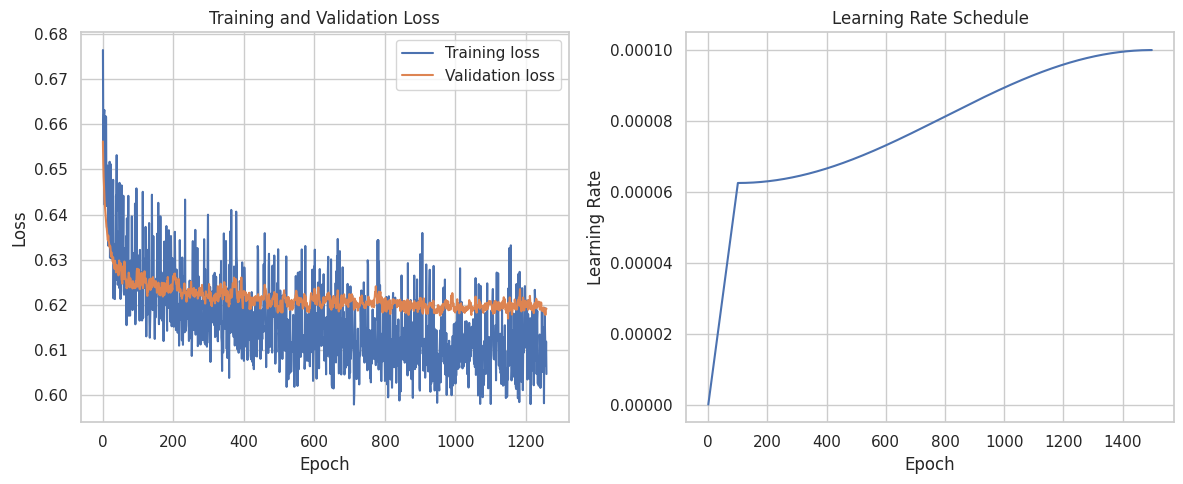

Optimal threshold for F1 score: 0.702
Test accuracy: 0.9581
Precision: 0.8919
Recall: 0.9167
F1 Score: 0.9041
Confusion Matrix: 
[[127   4]
 [  3  33]]


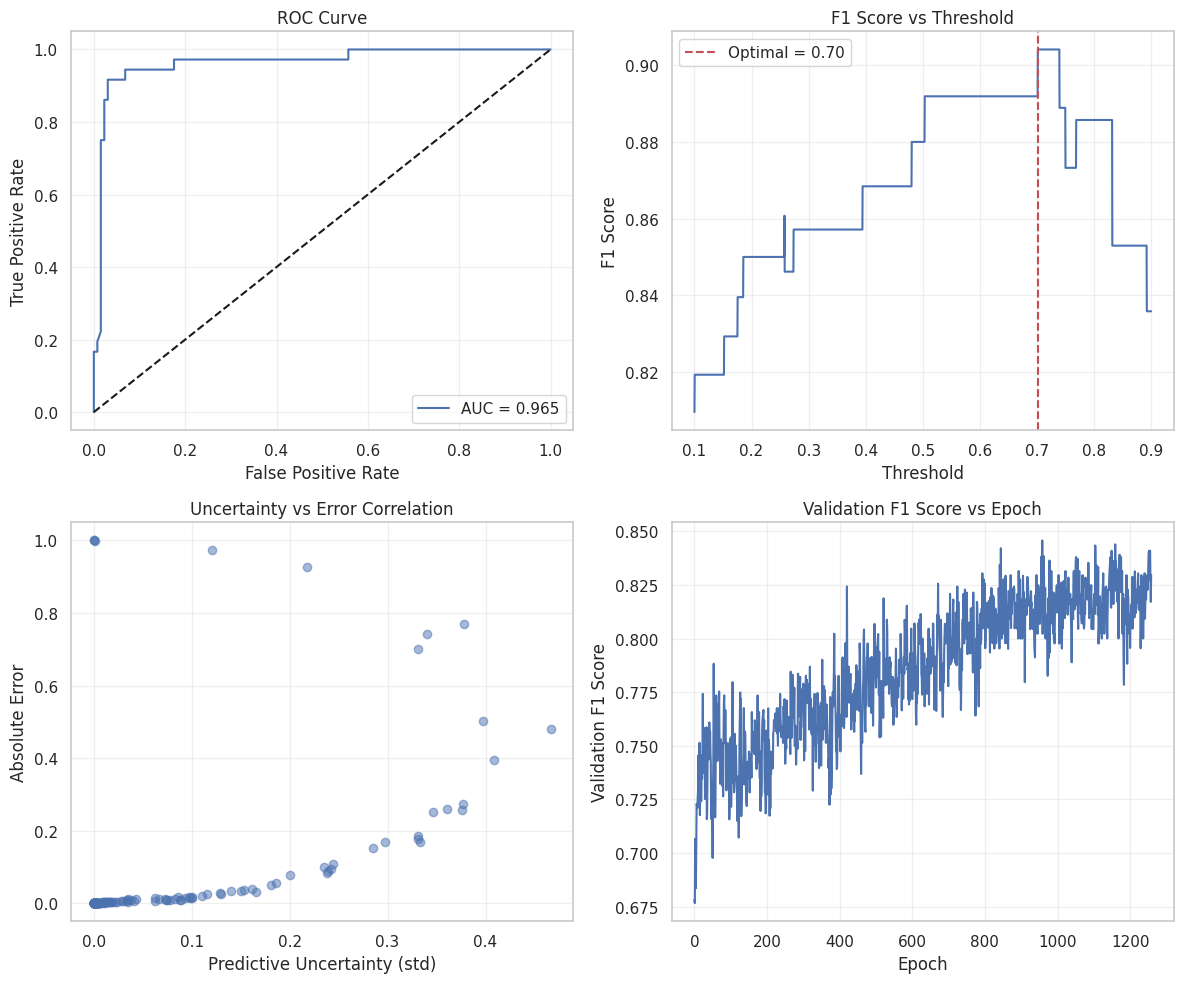

In [12]:
X = data_df.drop(y_col, axis=1).values
y = data_df[y_col].values

# Reshuffle the data (this will break down autocorrelation)
X_shuffled, y_shuffled = shuffle(X, y, random_state=42)

# Model parameters
params = {
    'hidden_dims': [64, 256, 1024, 32],  # Deeper network with varying widths
    'dropout_probs': [0.1, 0.1, 0.1, 0.1],  # Varying dropout rates
    'activation': 'gelu',  # Modern activation function
    'use_batch_norm': True,  # Use batch normalization
    'use_layer_norm': False,  # Use layer normalization
    'use_residual': True,  # Use residual connections
    'epochs': 1500,
    'batch_size': 32,
    'lr': 0.001,
    'weight_decay': 1e-4,  # L2 regularization
    'warmup_epochs': 100,
    'class_weights': 'auto',  # Automatically handle class imbalance
    'patience': 300,
    'loss': "SoftF1",  # values: "Focal", "BCE_w", "BCE", "SoftF1", "Hybrid", "NLL"
    'accumulation_steps': 4,  # Gradient accumulation steps
}

# Data preparation
data = data_preprocessing(X, y, batch_size=params['batch_size'])

# Train and evaluate the model
train_output = train_bnn(data, params)

# Plot model insights
plot_model_insight(data, params, train_output)
